# 1. Import dependencies

In [ ]:
!pip install stable-baselines3[extra]

In [1]:
import numpy as np
import pandas as pd
import os
import random
import time
import cv2
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
import matplotlib.pyplot as plt
from IPython.display import Image, display
from IPython.display import clear_output
%matplotlib inline

In [2]:
import gym 
from gym import Env
from gym.spaces import Discrete, Box, MultiDiscrete, Tuple
from gym import spaces

# 2. Load Environment

In [3]:
class EdgeEnv(Env):
    def __init__(self, mobile_user_count, edge_servers_computation_power):
        self.mobile_user_count = mobile_user_count
        
        self.slowest_cpu_cycle = 1 #GHz
        self.base_price = 1
        
#         Edge Server
        self.edge_servers_computation_power = edge_servers_computation_power # GHz

#         Mobile Device
        self.effective_switched_capacitance = 1e-27    
        self.transmission_power = 0.1 # ~ 100 mWatts
        self.ideal_power = 0.01 # ~ 10 mWatts
        
#         channel_bandwidth = 10 MHz
#         channel_gain = 130 + 30 * log2d
#         channel_noise = 2 * 10e-13
#         Pn = sending/transmission power of local device = 100mW
        self.channel_noise = 2 * 10e-13
    
        self.transmission_rate = 10 * math.log(1 + (((130 + 30 * math.log(100,2)) * (self.transmission_power)) / (self.channel_noise)),2) #Mbits/sec
        self.delay_factor = 1
        self.energy_factor = 1
        self.cost_factor = 1
        
        
#         action : <offloading decision vector,
#                 transmission_rate_assigned vector,
#                 computation_power_assigned vector>
        self.action_space = MultiDiscrete([2 for i in range(self.mobile_user_count)] + 
                                          [self.transmission_rate for i in range(self.mobile_user_count)] + 
                                          [self.edge_servers_computation_power for i in range(self.mobile_user_count)])

    
#         state : <fi,di,ci for all users>
        self.observation_space = Tuple((
            Box(0.5, 1, shape=(1,self.mobile_user_count)),
            Box(300, 500, shape=(1,self.mobile_user_count), dtype=int),
            Box(900, 1100, shape=(1,self.mobile_user_count), dtype=int)
        ))
        
        self.reset()
        
        
#         Mobile Device
#         fi = computing_power = 0.5 - 1 Ghz
#         di = data_size = 300KB - 500KB
#         ci = no. of cpu cycles = [900 - 1100] Megacycles
        
    
    def step(self, action):
        
        self.edge_computation_power_available = self.edge_servers_computation_power
        self.transmission_rate_available = self.transmission_rate
        self.delay_cost = 0
        self.energy_cost = 0
        self.price_cost = 0
        
            
        for i in range(self.mobile_user_count):
            if (action[0][i] < 0.5):
                self.delay_cost += self.local_delay[i]
                self.energy_cost += self.local_energy[i]
            
            else:
#                 tm = di / transmission_rate_assigned
                tm = self.users_state[i][1] / (action[0][self.mobile_user_count + i]*1000)
#                 tx = ci / edge_computation_power_assigned
                tx = self.users_state[i][2] / (action[0][2*self.mobile_user_count + i]*1000)
                self.delay_cost += (tm + tx)
                
#                 em = PT*tm
                em = (self.transmission_power * tm)
#                 ex = PI*tx        
                ex = (self.ideal_power * tx)
                self.energy_cost += (em+ex)
        
                self.price_cost += (tx*self.base_price*action[0][2*self.mobile_user_count + i]/self.slowest_cpu_cycle)
                
                self.edge_computation_power_available -= action[0][2*self.mobile_user_count + i]
                self.transmission_rate_available -= action[0][self.mobile_user_count + i]
                
        self.total_overhead = (self.delay_factor*self.delay_cost) + (self.energy_factor*self.energy_cost) + (self.cost_factor*self.price_cost)
        reward = (self.local_overhead - self.total_overhead) / self.local_overhead
            
        self.total_computation_power_assigned = self.edge_servers_computation_power - self.edge_computation_power_available
        self.total_transmission_rate_assigned = self.transmission_rate - self.transmission_rate_available

#         print('total_computation_power_assigned : ', self.total_computation_power_assigned , 'edge_servers_computation_power : ', self.edge_servers_computation_power)   
#         print('total_transmission_rate_assigned : ', self.total_transmission_rate_assigned , 'total transmission rate : ', self.transmission_rate)    
#         print('total_delay : ', self.delay_cost, 'total_energy : ', self.energy_cost, 'total_price_cost : ',self.price_cost, 'total overhead sum : ',self.delay_cost+self.energy_cost+self.price_cost)
#         print('total_current_overhead : ', self.total_overhead, 'local_overhead : ', self.local_overhead)
        
        if ((self.total_computation_power_assigned > self.edge_servers_computation_power) or 
        (self.total_transmission_rate_assigned > self.transmission_rate)):
            reward = 0
        
        next_state = state
        done = True
        info = {}
        
        return next_state, reward, done, info
    

    def render(self):
        # Implement viz
        pass
    
    def set_users_state(self,custom_state):
        # fi, di, ci
        self.users_state = custom_state
        
        k = self.effective_switched_capacitance
        
        self.local_delay = [(user[2] / (float(user[0])*1000)) for user in self.users_state]
        self.local_energy = [k*(user[0]*user[0])*user[2]*1e24 for user in self.users_state]
        
        self.local_overheads = [(self.delay_factor*delay) + (self.energy_factor*energy) for delay,energy in zip(self.local_delay, self.local_energy)]
        self.local_overhead = (self.delay_factor*sum(self.local_delay)) + (self.energy_factor*sum(self.local_energy))
        
        self.state = np.array([self.users_state[i][0] for i in range(self.mobile_user_count)] + 
                             [self.users_state[i][1] for i in range(self.mobile_user_count)] +
                             [self.users_state[i][2] for i in range(self.mobile_user_count)])
        
        return self.users_state,self.state
    
    
    def set_state(self,state):
        # fi, di, ci
        custom_state = [[state[i],state[i+self.mobile_user_count],state[i+2*self.mobile_user_count]]
                          for i in range(self.mobile_user_count)]
        return self.set_users_state(custom_state)
    
    
    def reset(self):
        # fi, di, ci
        self.users_state = [[random.uniform(0.5,1), random.randint(300,500), random.randint(900,1100)] 
                            for i in range(self.mobile_user_count)]
        
        k = self.effective_switched_capacitance
        
        self.local_delay = [(user[2] / (float(user[0])*1000)) for user in self.users_state]
        self.local_energy = [k*(user[0]*user[0])*user[2]*1e24 for user in self.users_state]
        
        self.local_overheads = [(self.delay_factor*delay) + (self.energy_factor*energy) for delay,energy in zip(self.local_delay, self.local_energy)]
        self.local_overhead = (self.delay_factor*sum(self.local_delay)) + (self.energy_factor*sum(self.local_energy))
        
        self.state = np.array([self.users_state[i][0] for i in range(self.mobile_user_count)] + 
                             [self.users_state[i][1] for i in range(self.mobile_user_count)] +
                             [self.users_state[i][2] for i in range(self.mobile_user_count)])
    
        return self.users_state,self.state
    

# Understanding The Environment

In [4]:
env = EdgeEnv(3,10)

In [5]:
env.action_space.sample(),env.action_space.sample().shape

(array([  0,   1,   1, 127, 397, 144,   9,   5,   0], dtype=int64), (9,))

In [6]:
env.observation_space.sample(),np.array(env.observation_space.sample()).shape

((array([[0.76840425, 0.5367211 , 0.9025734 ]], dtype=float32),
  array([[476, 422, 443]]),
  array([[ 935,  961, 1016]])),
 (3, 1, 3))

In [7]:
obs=env.observation_space.sample()

merge_arr = np.concatenate([obs[i][0] for i in range(3)], axis=0)
merge_arr,merge_arr.shape

(array([6.57486737e-01, 8.84072125e-01, 5.63614666e-01, 3.89000000e+02,
        4.72000000e+02, 3.99000000e+02, 1.06400000e+03, 1.01700000e+03,
        9.97000000e+02]),
 (9,))

In [8]:
env.state

array([8.75048924e-01, 5.08479612e-01, 8.69595752e-01, 3.01000000e+02,
       4.34000000e+02, 3.26000000e+02, 9.85000000e+02, 1.05100000e+03,
       1.08600000e+03])

In [9]:
env.transmission_rate, env.transmission_power

(439.04536464366436, 0.1)

In [10]:
env.reset()

([[0.9119871238487193, 383, 1030],
  [0.9071734523600126, 369, 1010],
  [0.9179708300806387, 307, 1082]],
 array([9.11987124e-01, 9.07173452e-01, 9.17970830e-01, 3.83000000e+02,
        3.69000000e+02, 3.07000000e+02, 1.03000000e+03, 1.01000000e+03,
        1.08200000e+03]))

# Defining the QN Agent

In [11]:
class QNAgent():
    def __init__(self, env, discount_rate=0.97, learning_rate=0.2):
#         super().__init__(env)
        self.env = env
        self.state_length = len(env.observation_space.sample())
        print("State vector length:", self.state_length)
        
        self.eps = 0.5
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
#         self.build_model()
        self.model1=self.build_model()
        self.model2=self.build_model()
        self.copy_weights(self.model1)
        
    def build_model(self):
#         state_shape = np.array(self.env.observation_space.sample()).shape
        state_shape = np.array(self.env.state).shape
        action_shape = self.env.action_space.sample().shape
        print('state_shape : ',state_shape,' action_shape : ',action_shape)
        init = tf.keras.initializers.he_uniform()
        model = keras.Sequential()
        model.add(keras.layers.Dense(24, input_shape=state_shape, activation='relu', kernel_initializer=init))
        model.add(keras.layers.Dense(12, activation='relu', kernel_initializer=init))
        model.add(keras.layers.Dense(action_shape[0], activation='linear', kernel_initializer=init))
        model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(lr=self.learning_rate), metrics=['accuracy'])
#         self.model = model
        return model
        
        
    def generate_random_action(self):
        action = [[random.randint(0,1) for i in range(self.env.mobile_user_count)] +
                    [random.randint(1,int(self.env.transmission_rate)) for i in range(self.env.mobile_user_count)] +
                    [random.randint(0,self.env.edge_servers_computation_power) for i in range(self.env.mobile_user_count)]]
        return action
        
    
    def get_action(self, state):
        q_state = self.model1(np.atleast_2d(state).astype(np.float32))
        action_greedy = q_state.numpy()
        action_random = np.atleast_2d(self.generate_random_action())
#         action_random = np.atleast_2d(self.env.action_space.sample())
        action_random = action_random.astype('float64')
        action = action_random if random.random() < self.eps else action_greedy
        
#         print('action : ',action)
        
        sm1=0
        sm2=0
        for i in range(self.env.mobile_user_count):
            if action[0][i]>=0.5 :
                action[0][i]=1
                if action[0][i+self.env.mobile_user_count]<0 :
                    action[0][i+self.env.mobile_user_count]=abs(action[0][i+self.env.mobile_user_count])
                if action[0][i+self.env.mobile_user_count]==0 :
                    action[0][i+self.env.mobile_user_count]=1
                sm1+=action[0][i+self.env.mobile_user_count]
                
                if action[0][i+2*self.env.mobile_user_count]<0 :
                    action[0][i+2*self.env.mobile_user_count]=abs(action[0][i+2*self.env.mobile_user_count])
                if action[0][i+2*self.env.mobile_user_count]==0 :
                    action[0][i+2*self.env.mobile_user_count]=1
                sm2+=action[0][i+2*self.env.mobile_user_count]
                
            else :
                action[0][i]=0
                action[0][i+self.env.mobile_user_count]=0
                action[0][i+2*self.env.mobile_user_count]=0
                
        for i in range(self.env.mobile_user_count):
            if action[0][i]>=0.5:
                action[0][i+self.env.mobile_user_count]=(action[0][i+self.env.mobile_user_count]*(self.env.transmission_rate-1))/sm1
                action[0][i+2*self.env.mobile_user_count]=(action[0][i+2*self.env.mobile_user_count]*(self.env.edge_servers_computation_power-1))/sm2
    
#         print('action : ',action)
        
        return action
    
    
    def predict_action(self, state):
        q_state = self.model2(np.atleast_2d(state).astype(np.float32))
        action = q_state.numpy()
        
        sm1=0
        sm2=0
        for i in range(self.env.mobile_user_count):
            if action[0][i]>=0.5 :
                action[0][i]=1
                if action[0][i+self.env.mobile_user_count]<0 :
                    action[0][i+self.env.mobile_user_count]=abs(action[0][i+self.env.mobile_user_count])
                if action[0][i+self.env.mobile_user_count]==0 :
                    action[0][i+self.env.mobile_user_count]=1
                sm1+=action[0][i+self.env.mobile_user_count]
                
                if action[0][i+2*self.env.mobile_user_count]<0 :
                    action[0][i+2*self.env.mobile_user_count]=abs(action[0][i+2*self.env.mobile_user_count])
                if action[0][i+2*self.env.mobile_user_count]==0 :
                    action[0][i+2*self.env.mobile_user_count]=1
                sm2+=action[0][i+2*self.env.mobile_user_count]
                
            else :
                action[0][i]=0
                action[0][i+self.env.mobile_user_count]=0
                action[0][i+2*self.env.mobile_user_count]=0
                
        for i in range(self.env.mobile_user_count):
            if action[0][i]>=0.5:
                action[0][i+self.env.mobile_user_count]=(action[0][i+self.env.mobile_user_count]*(self.env.transmission_rate-1))/sm1
                action[0][i+2*self.env.mobile_user_count]=(action[0][i+2*self.env.mobile_user_count]*(self.env.edge_servers_computation_power-1))/sm2
    
#         print('action : ',action)
        
        return action
    
    
    def train(self, experience):
        state, action, next_state, reward, best_action = (exp for exp in experience)
        q_next = self.model1(np.atleast_2d(state).astype(np.float32))
        X=[]
        Y=[]
        X.append(state)
        Y.append(action)
#         r = max_future_q = reward + discount_factor * np.max(future_qs_list[index])
        self.model.fit(np.array(X), np.array(Y), batch_size=1, verbose=0, shuffle=True)
        
#         self.eps = self.eps * 0.99


    
    def train(self, experience):
        state, action, next_state, reward, done = (exp for exp in experience)
        q_next = self.model1(np.atleast_2d(state).astype(np.float32))
        X=[]
        Y=[]
        X.append(state)
        Y.append(action)
#         r = max_future_q = reward + discount_factor * np.max(future_qs_list[index])
        self.model1.fit(np.array(X), np.array(Y), batch_size=1, verbose=0, shuffle=True)
        
#         self.eps = self.eps * 0.99


    def copy_weights(self, model1):
        variables1 = model1.trainable_variables
        variables2 = self.model2.trainable_variables
        for v1, v2 in zip(variables1, variables2):
            v2.assign(v1.numpy())
            
    def __del__(self):
        print("__del__ method running")
        
agent = QNAgent(env)

State vector length: 3
state_shape :  (9,)  action_shape :  (9,)
state_shape :  (9,)  action_shape :  (9,)


# Testing Model

In [12]:
users_state,state = env.reset()
state

array([6.60504678e-01, 8.53926616e-01, 9.28852691e-01, 3.63000000e+02,
       3.88000000e+02, 4.51000000e+02, 1.09000000e+03, 1.04200000e+03,
       9.79000000e+02])

In [13]:
total_reward = 0
for ep in range(100):
    users_state,state = env.reset()
    done = False
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        if reward>0 :
            agent.train((state,action,next_state,reward,done))
        total_reward += reward
        
#         print("s:", state)
        print("a:", action)
        print('total_delay : ', env.delay_cost, 'total_energy : ', env.energy_cost, 'total_price_cost : ',env.price_cost, 'total overhead sum : ',env.delay_cost+env.energy_cost+env.price_cost)
        print('total_current_overhead : ', env.total_overhead, 'local_overhead : ', env.local_overhead)
        print("r:", reward)
        print("Episode: {}, Total reward: {}, eps: {}".format(ep,total_reward,agent.eps))
        print('***********************************************************************************************************\n')

a: [[  0.           0.           1.           0.           0.
  438.04536464   0.           0.           9.        ]]
total_delay :  3.7082494353006026 total_energy :  0.6534632891556508 total_price_cost :  0.9820000000000001 total overhead sum :  5.343712724456253
total_current_overhead :  5.343712724456253 local_overhead :  6.136363975939052
r: 0.1291727893897458
Episode: 0, Total reward: 0.1291727893897458, eps: 0.5
***********************************************************************************************************

a: [[  1.          1.          1.        178.74617   188.20308    71.096115
    1.9694326   0.9531936   6.077374 ]]
total_delay :  1.818699474781154 total_energy :  0.019231373419518 total_price_cost :  3.0570000000000004 total overhead sum :  4.894930848200673
total_current_overhead :  4.894930848200673 local_overhead :  5.836792621940905
r: 0.16136632475166396
Episode: 1, Total reward: 0.29053911414140976, eps: 0.5
***********************************************

Episode: 18, Total reward: 1.9736057109029121, eps: 0.5
***********************************************************************************************************

a: [[  0.           1.           1.           0.         222.09309376
  215.95227089   0.           7.875        1.125     ]]
total_delay :  2.1691021557821264 total_energy :  0.7341645303302563 total_price_cost :  1.955 total overhead sum :  4.858266686112383
total_current_overhead :  4.858266686112383 local_overhead :  5.67769892257579
r: 0.14432470753339222
Episode: 19, Total reward: 2.1179304184363046, eps: 0.5
***********************************************************************************************************

a: [[  1.           0.           1.         191.86386971   0.
  246.18149493   5.78571429   0.           3.21428571]]
total_delay :  1.980841155758808 total_energy :  0.42495141696174976 total_price_cost :  1.854 total overhead sum :  4.259792572720558
total_current_overhead :  4.259792572720558 local_over

a: [[  1.           0.           1.         328.31278845   0.
  109.73257619   5.72727273   0.           3.27272727]]
total_delay :  1.8552003510901014 total_energy :  0.6185638755950108 total_price_cost :  1.8079999999999998 total overhead sum :  4.281764226685112
total_current_overhead :  4.281764226685112 local_overhead :  5.457511896849604
r: 0.21543657483242537
Episode: 35, Total reward: 6.370610224855814, eps: 0.5
***********************************************************************************************************

a: [[  1.           0.           0.         438.04536464   0.
    0.           9.           0.           0.        ]]
total_delay :  3.07250915286351 total_energy :  1.039554916773223 total_price_cost :  0.909 total overhead sum :  5.021064069636733
total_current_overhead :  5.021064069636733 local_overhead :  5.745076552207657
r: 0.12602312188385165
Episode: 36, Total reward: 6.4966333467396655, eps: 0.5
**********************************************************

a: [[  1.          1.          1.        140.87302   155.26945   141.90288
    3.2339675   2.9502788   2.8157537]]
total_delay :  1.032097665200597 total_energy :  0.01107205603777524 total_price_cost :  3.0570000000000004 total overhead sum :  4.100169721238373
total_current_overhead :  4.100169721238373 local_overhead :  5.857008843281083
r: 0.29995500588292306
Episode: 51, Total reward: 10.595645886630496, eps: 0.5
***********************************************************************************************************

a: [[  0.           1.           1.           0.         432.703348
    5.34201664   0.           8.           1.        ]]
total_delay :  2.3189048572833846 total_energy :  0.6083235665839918 total_price_cost :  1.939 total overhead sum :  4.866228423867376
total_current_overhead :  4.866228423867376 local_overhead :  5.673277415595002
r: 0.14225445586517008
Episode: 52, Total reward: 10.737900342495667, eps: 0.5
***************************************************

a: [[  0.           1.           1.           0.         229.42403087
  208.62133377   0.           7.5          1.5       ]]
total_delay :  1.8266564111986812 total_energy :  0.9861957151030344 total_price_cost :  2.003 total overhead sum :  4.815852126301715
total_current_overhead :  4.815852126301715 local_overhead :  5.8756558355961115
r: 0.18037198551927683
Episode: 69, Total reward: 15.39078933323598, eps: 0.5
***********************************************************************************************************

a: [[  1.          1.          1.        127.8399    155.95792   154.24756
    2.4658208   3.445468    3.0887115]]
total_delay :  1.0464369911311349 total_energy :  0.011227957577497148 total_price_cost :  3.082 total overhead sum :  4.139664948708631
total_current_overhead :  4.139664948708631 local_overhead :  6.152364426036828
r: 0.3271424346728301
Episode: 70, Total reward: 15.71793176790881, eps: 0.5
**************************************************************

a: [[  1.           0.           0.         438.04536464   0.
    0.           9.           0.           0.        ]]
total_delay :  3.3460245958442076 total_energy :  0.790214801646318 total_price_cost :  1.03 total overhead sum :  5.166239397490526
total_current_overhead :  5.166239397490526 local_overhead :  5.966319888317699
r: 0.1340994961389455
Episode: 85, Total reward: 19.22660718095894, eps: 0.5
***********************************************************************************************************

a: [[  1.          0.          1.        200.52013     0.        237.52524
    3.7519195   0.          5.2480807]]
total_delay :  1.9505869248301337 total_energy :  0.344458459977307 total_price_cost :  1.9930000000000003 total overhead sum :  4.288045384807441
total_current_overhead :  4.288045384807441 local_overhead :  5.6190415420163315
r: 0.23687245364825632
Episode: 86, Total reward: 19.463479634607197, eps: 0.5
*************************************************************

In [14]:
total_reward = 0
for ep in range(1):
    custom_state = np.array([[0.5, 400, 1100],
                            [0.75, 500, 1000],
                            [1, 300, 900]])
    users_state,state = env.set_users_state(custom_state)
    done = False
    while not done:
        action = agent.predict_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        
#         print("s:", state)
#         print("a:", action)
        print('total_delay : ', env.delay_cost, 'total_energy : ', env.energy_cost, 'total_price_cost : ',env.price_cost, 'total overhead sum : ',env.delay_cost+env.energy_cost+env.price_cost)
        print('total_current_overhead : ', env.total_overhead, 'local_overhead : ', env.local_overhead)
        print("r:", reward)
        print('***********************************************************************************************************\n')

total_delay :  4.433333333333334 total_energy :  1.7375 total_price_cost :  0 total overhead sum :  6.170833333333333
total_current_overhead :  6.170833333333333 local_overhead :  6.170833333333333
r: 0.0
***********************************************************************************************************



In [15]:
# env.close()

# Edge Execution function

In [16]:
def edge_execution(env,agent):
    action = [[1 for i in range(env.mobile_user_count)] +
                [env.transmission_rate/env.mobile_user_count for i in range(env.mobile_user_count)] +
                [env.edge_servers_computation_power/env.mobile_user_count for i in range(env.mobile_user_count)]]
    
#     action = np.atleast_2d(env.action_space.sample())
#     action = action.astype('float64')
    
#     sm1=0
#     sm2=0
#     for i in range(env.mobile_user_count):
#         action[0][i]=1
#         if action[0][env.mobile_user_count + i]==0:
#             action[0][env.mobile_user_count + i] = 1
#         sm1+=action[0][env.mobile_user_count + i]
#         if action[0][2*env.mobile_user_count + i]==0:
#             action[0][2*env.mobile_user_count + i] = 1 
#         sm2+=action[0][2*env.mobile_user_count + i]
    
#     for i in range(env.mobile_user_count):
#         action[0][i+env.mobile_user_count]=(action[0][i+env.mobile_user_count]*env.transmission_rate-1)/sm1
#         action[0][i+2*env.mobile_user_count]=(action[0][i+2*env.mobile_user_count]*env.edge_servers_computation_power-1)/sm2
    
    next_state, reward, done, info = env.step(action)

    print("s:", env.state)
    print("a:", action)
    print("r:", reward)

# Training and Testing functions

In [17]:
def train_agent(env,agent,iterations):
    total_reward=0
    for ep in range(iterations):
        users_state,state = env.reset()
        done = False
#         while not done:
        for i in range(20):
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            if reward>0:
                agent.train((state,action,next_state,reward,action))
            total_reward += reward
            
#         print("s:", state)
#         print("a:", action)
        print('total_delay : ', env.delay_cost, 'total_energy : ', env.energy_cost, 'total_price_cost : ',env.price_cost, 'total overhead sum : ',env.delay_cost+env.energy_cost+env.price_cost)
        print('total_current_overhead : ', env.total_overhead, 'local_overhead : ', env.local_overhead)
        print("r:", reward)
        print("Episode: {}, Total reward: {}".format(ep,total_reward))
        print('***********************************************************************************************************\n')

In [18]:
def test_prediction(env,agent):
#     action = agent.model(np.atleast_2d(state).astype(np.float32)).numpy()
    action = agent.predict_action(env.state)
    next_state, reward, done, info = env.step(action)

    print("s:", env.state)
    print("a:", action)
    print("r:", reward)

In [19]:
def train_test_agents(mobile_user_count,envs,agents,data_local,data_predicted,data_edge):
    overheads_local={}
    overheads_predicted={}
    overheads_edge={}
    envs_obj={}
    agents_obj={}
    for i in range(2,11):
        clear_output(wait=True)
        env = EdgeEnv(mobile_user_count,i)
        agent = QNAgent(env)
        users_state,state = env.reset()
    #     print('state :',state)
        train_agent(env,agent,1000)
        users_state,state = env.set_state(test_data[mobile_user_count])
        test_prediction(env,agent)
        envs_obj[i]=env
        agents_obj[i]=agent
        overheads_local[i]=env.local_overhead
        overheads_predicted[i]=env.total_overhead
        edge_execution(env,agent)
        overheads_edge[i]=env.total_overhead
#         env.close()

    envs[mobile_user_count]=envs_obj
    agents[mobile_user_count]=agents_obj
    data_local[mobile_user_count]=overheads_local
    data_predicted[mobile_user_count]=overheads_predicted
    data_edge[mobile_user_count]=overheads_edge

In [20]:
def train_test_agents_2(mobile_user_count,envs,agents,data_local,data_predicted,data_edge):
    overheads_local={}
    overheads_predicted={}
    overheads_edge={}
    for i in range(2,11):
        clear_output(wait=True)
        env = envs[mobile_user_count][i]
        agent = agents[mobile_user_count][i]
        users_state,state = env.reset()
    #     print('state :',state)
        train_agent(env,agent,1000)
        users_state,state = env.set_state(test_data[mobile_user_count])
        test_prediction(env,agent)
        overheads_local[i]=env.local_overhead
        overheads_predicted[i]=env.total_overhead
        edge_execution(env,agent)
        overheads_edge[i]=env.total_overhead
#         env.close()

    data_local[mobile_user_count]=overheads_local
    data_predicted[mobile_user_count]=overheads_predicted
    data_edge[mobile_user_count]=overheads_edge

In [21]:
def train_test_agent(env,agent,data_local,data_predicted,data_edge):
    users_state,state = env.reset()
#     print('state :',state)
    train_agent(env,agent,1000)
    users_state,state = env.set_state(test_data[env.mobile_user_count])
    test_prediction(env,agent)
    data_local[env.mobile_user_count][10]=env.local_overhead
    data_predicted[env.mobile_user_count][10]=env.total_overhead
    edge_execution(env,agent)
    data_edge[env.mobile_user_count][10]=env.total_overhead
#     env.close()

# Testing Data

In [22]:
t_data=pd.read_csv('test_data.csv',index_col='users')

In [23]:
t_data

,test_data
users,
3,"[0.9157491179366234, 0.6997358150024131, 0.588..."
5,"[0.7806586956643597, 0.6064884130044812, 0.975..."
8,"[0.6254107014095633, 0.8982025454475453, 0.635..."
10,"[0.5577638855045846, 0.7276852303814516, 0.593..."
15,"[0.8588861383496823, 0.6174354081426809, 0.850..."
20,"[0.7632384725569963, 0.9497111258578739, 0.738..."


In [24]:
test_data = {}
for i in range(t_data.size):
    data = t_data.iloc[i][0].strip('][').split(', ')
    test_data[t_data.iloc[i].name] = [float(i) for i in data]
test_data

{3: [0.9157491179366234,
  0.6997358150024131,
  0.5887001438105987,
  480.0,
  390.0,
  374.0,
  943.0,
  1085.0,
  982.0],
 5: [0.7806586956643597,
  0.6064884130044812,
  0.9759101388593943,
  0.5167202450646844,
  0.9073767030149813,
  399.0,
  412.0,
  499.0,
  480.0,
  461.0,
  1055.0,
  1067.0,
  1087.0,
  904.0,
  946.0],
 8: [0.6254107014095633,
  0.8982025454475453,
  0.6357020005346172,
  0.9789958023355458,
  0.5820992095925386,
  0.6306144768337594,
  0.5679659416308087,
  0.8495400592596803,
  379.0,
  313.0,
  315.0,
  304.0,
  451.0,
  423.0,
  482.0,
  443.0,
  1082.0,
  986.0,
  932.0,
  1054.0,
  1016.0,
  1035.0,
  1051.0,
  1037.0],
 10: [0.5577638855045846,
  0.7276852303814516,
  0.5933947265745032,
  0.7812941861046576,
  0.5202355764185231,
  0.9939747655459596,
  0.6114823373417493,
  0.8724624750865999,
  0.7462078525116254,
  0.9662014411755349,
  350.0,
  323.0,
  400.0,
  441.0,
  346.0,
  480.0,
  393.0,
  420.0,
  327.0,
  491.0,
  952.0,
  924.0,
  964.

# Testing for 3, 5, 8, 10, 15, 20 users

In [25]:
envs={}
agents={}
data_local={}
data_predicted={}
data_edge={}

In [ ]:
train_test_agents(3,envs,agents,data_local,data_predicted,data_edge)

In [ ]:
train_test_agents(5,envs,agents,data_local,data_predicted,data_edge)

In [ ]:
train_test_agents(8,envs,agents,data_local,data_predicted,data_edge)

In [ ]:
train_test_agents(10,envs,agents,data_local,data_predicted,data_edge)

In [ ]:
train_test_agents(15,envs,agents,data_local,data_predicted,data_edge)

In [ ]:
train_test_agents(20,envs,agents,data_local,data_predicted,data_edge)

In [ ]:
# train_test_agents_2(3,envs,agents,data_local,data_predicted,data_edge)

In [ ]:
# train_test_agents_2(5,envs,agents,data_local,data_predicted,data_edge)

In [ ]:
# train_test_agents_2(8,envs,agents,data_local,data_predicted,data_edge)

In [ ]:
# train_test_agents_2(10,envs,agents,data_local,data_predicted,data_edge)

In [ ]:
# train_test_agents_2(15,envs,agents,data_local,data_predicted,data_edge)

In [ ]:
# train_test_agents_2(20,envs,agents,data_local,data_predicted,data_edge)

In [ ]:
# train_test_agent(envs[3][10],agents[3][10],data_local,data_predicted,data_edge)

In [ ]:
# train_test_agent(envs[5][10],agents[5][10],data_local,data_predicted,data_edge)

In [ ]:
# train_test_agent(envs[8][10],agents[8][10],data_local,data_predicted,data_edge)

In [ ]:
# train_test_agent(envs[10][10],agents[10][10],data_local,data_predicted,data_edge)

In [ ]:
# train_test_agent(envs[15][10],agents[15][10],data_local,data_predicted,data_edge)

In [ ]:
# train_test_agent(envs[20][10],agents[20][10],data_local,data_predicted,data_edge)

# Overheads data

In [ ]:
envs,agents,data_local,data_predicted,data_edge

In [ ]:
df_overheads_local=pd.DataFrame(data_local)
df_overheads_local.index = [i for i in range(2,11)]
df_overheads_local

In [ ]:
df_overheads_predicted=pd.DataFrame(data_predicted)
df_overheads_predicted.index = [i for i in range(2,11)]
df_overheads_predicted

In [ ]:
df_overheads_edge=pd.DataFrame(data_edge)
df_overheads_edge.index = [i for i in range(2,11)]
df_overheads_edge

In [48]:
df_overheads_local.to_csv('overheads_local.csv')
df_overheads_predicted.to_csv('overheads_dqn.csv')
df_overheads_edge.to_csv('overheads_edge.csv')

In [71]:
df_overheads_local=pd.read_csv('overheads_local.csv',index_col='Unnamed: 0')
df_overheads_local

,3,5,8,10,15,20
2,5.9108,10.107544,16.27713,19.502755,29.271232,39.226723
3,5.9108,10.107544,16.27713,19.502755,29.271232,39.226723
4,5.9108,10.107544,16.27713,19.502755,29.271232,39.226723
5,5.9108,10.107544,16.27713,19.502755,29.271232,39.226723
6,5.9108,10.107544,16.27713,19.502755,29.271232,39.226723
7,5.9108,10.107544,16.27713,19.502755,29.271232,39.226723
8,5.9108,10.107544,16.27713,19.502755,29.271232,39.226723
9,5.9108,10.107544,16.27713,19.502755,29.271232,39.226723
10,5.9108,10.107544,16.27713,19.502755,29.271232,39.226723


In [72]:
df_overheads_predicted=pd.read_csv('overheads_dqn.csv',index_col='Unnamed: 0')
df_overheads_predicted

,3,5,8,10,15,20
2,4.202173,13.507808,47.364782,18.313344,216.483592,137.585417
3,3.171801,5.385557,23.370936,17.774414,56.198021,105.220659
4,2.750119,4.886990,22.709933,14.849123,24.745388,301.658410
5,3.078542,4.846240,8.135240,14.384704,36.164444,135.216980
6,3.306432,5.496728,10.761360,13.078992,27.128249,24.271952
7,2.470278,4.799980,7.922139,9.841063,23.286901,46.254342
8,2.692975,7.412393,7.665397,9.334608,17.460292,41.254220
9,2.184956,7.481354,17.672969,11.966026,181.501056,33.053846
10,2.341720,4.745476,7.873118,15.419163,16.413512,29.567279


In [73]:
df_overheads_edge=pd.read_csv('overheads_edge.csv',index_col='Unnamed: 0')
df_overheads_edge

,3,5,8,10,15,20
2,7.579500,17.861174,41.355055,59.328991,128.337743,222.725700
3,6.059450,13.603182,30.321815,42.849158,90.619293,155.298100
4,5.299425,11.474186,24.805195,34.609241,71.760068,121.584300
5,4.843410,10.196789,21.495223,29.665291,60.444533,101.356020
6,4.539400,9.345190,19.288575,26.369324,52.900843,87.870500
7,4.322250,8.736906,17.712398,24.015062,47.512493,78.237986
8,4.159388,8.280692,16.530265,22.249366,43.471230,71.013600
9,4.032717,7.925860,15.610829,20.876046,40.328026,65.394634
10,3.931380,7.641994,14.875279,19.777391,37.813463,60.899460


# Results

In [74]:
Users = [3,5,8,10,15,20]

In [75]:
df_overheads_local.loc[10].tolist(),df_overheads_predicted.loc[10].tolist(),df_overheads_edge.loc[10].tolist()

([5.910799897214974,
  10.107543965359037,
  16.277130475773046,
  19.50275496312033,
  29.27123153994794,
  39.22672312106137],
 [2.3417204813555896,
  4.745476222371515,
  7.873118486609709,
  15.419162874125572,
  16.413512350746462,
  29.56727922218396],
 [3.9313802866231873,
  7.6419936805852,
  14.875279244154584,
  19.777390857933213,
  37.81346274079817,
  60.899460178135])

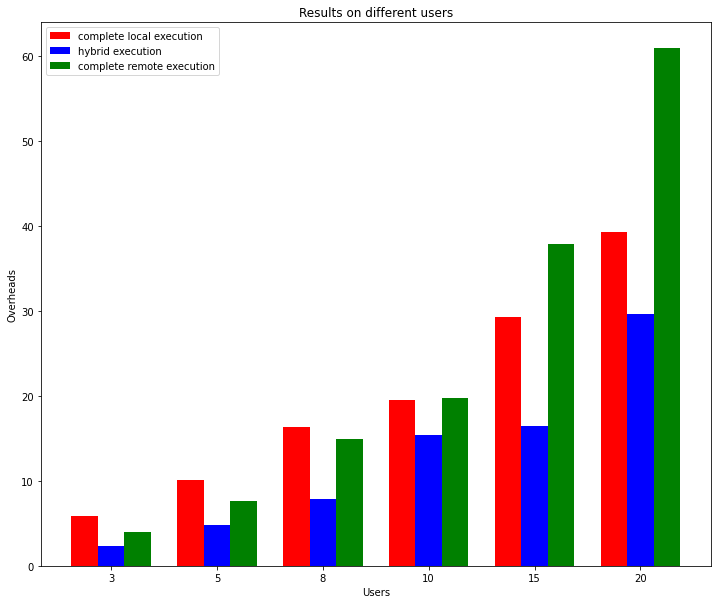

In [76]:
barWidth = 0.25

fig = plt.subplots(figsize =(12, 10))
 
br1 = np.arange(len(Users))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

plt.bar(br1, df_overheads_local.loc[10].tolist(),color = "red",width = barWidth,label ='complete local execution')
plt.bar(br2, df_overheads_predicted.loc[10].tolist(),color = "blue",width = barWidth,label ='hybrid execution')
plt.bar(br3, df_overheads_edge.loc[10].tolist(),color = "green",width = barWidth,label ='complete remote execution')

plt.xlabel("Users")
plt.ylabel("Overheads")
plt.xticks([r + barWidth for r in range(len(Users))],Users)
plt.title("Results on different users")
plt.legend()
plt.show()

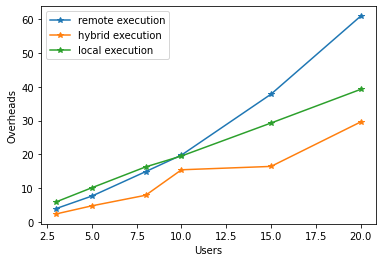

In [77]:
plt.plot(Users, df_overheads_edge.loc[10].tolist(), marker='*', label = "remote execution")
plt.plot(Users, df_overheads_predicted.loc[10].tolist(), marker='*', label = "hybrid execution")
plt.plot(Users, df_overheads_local.loc[10].tolist(), marker='*', label = "local execution")
plt.xlabel("Users")
plt.ylabel("Overheads")
plt.legend()
plt.show()

In [79]:
plt.plot([i for i in range(2,11)], df_overheads_edge[15].tolist(), marker='*', label = "remote execution")
plt.plot([i for i in range(2,11)], df_overheads_predicted[15].tolist(), marker='*', label = "hybrid execution")
plt.plot([i for i in range(2,11)], df_overheads_local[15].tolist(), marker='*', label = "local execution")
plt.xlabel("Edge Server's computation power")
plt.ylabel("Overheads")
plt.legend()
plt.show()